In [285]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [286]:
import keras

In [287]:
import os
import cv2
import numpy as np
import glob as gb
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.models import load_model


from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

In [288]:
root_directory = '/Users/arnavvyas/Downloads/Semantic_segmentation_dataset/'

patch_size = 224

In [289]:
image_dataset = []  
for folder in os.listdir(root_directory):
    files=gb.glob(root_directory+folder+'/images/*.jpg')
    for file in files :
        image = cv2.imread(file, 1)  #Read each image as BGR
        #crop images rather than resizing them
        SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
        SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
        image = Image.fromarray(image)
        image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
        #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
        image = np.array(image)             
        #use patchify to create patches of dimensions patch_size x patch_size, with '3' representing the number of input channels (RGB)
        patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):

                single_patch_img = patches_img[i,j,:,:]

                #Use minmaxscaler instead of just dividing by 255.
                #using minmaxscaler normalizes the patch's pixel intensity's, so no pixel value/color dominates over another and all pixels have similar values
                single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

                #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                image_dataset.append(single_patch_img)
        

In [290]:
image_dataset = np.array(image_dataset)

In [291]:
image_dataset.shape

(1647, 224, 224, 3)

In [292]:
mask_dataset = []  
for folder in os.listdir(root_directory):
    files=gb.glob(root_directory+folder+'/masks/*.png')
    for file in files :
        mask = cv2.imread(file, 1)  #Read each image as BGR
        mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
        SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
        SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
        mask = Image.fromarray(mask)
        mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
        #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
        mask = np.array(mask)             
        
        patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        for i in range(patches_mask.shape[0]):
            for j in range(patches_mask.shape[1]):

                single_patch_mask = patches_mask[i,j,:,:]
                
                #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                mask_dataset.append(single_patch_mask)
        

In [293]:
mask_dataset =  np.array(mask_dataset)

In [294]:
mask_dataset.shape

(1647, 224, 224, 3)

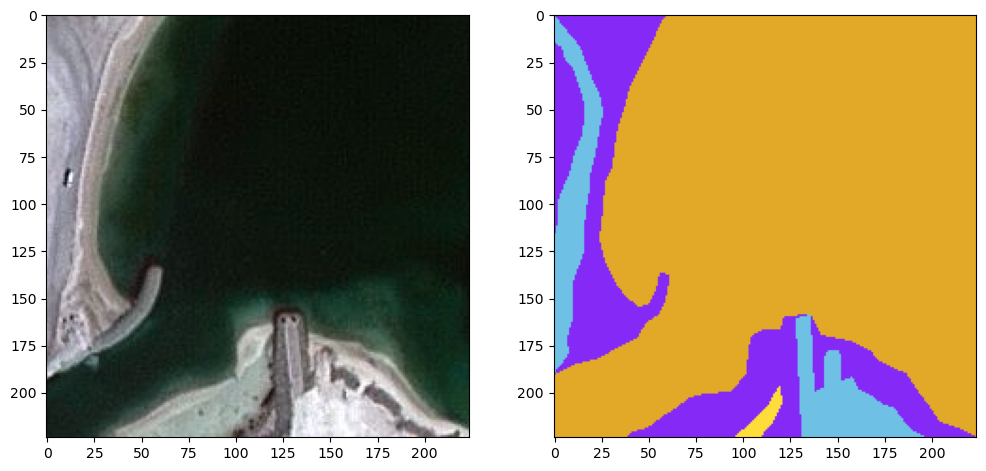

In [295]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [296]:
Building = '#3C1098'.lstrip('#') #dark purple
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#') #light purple
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') #cyan
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  '#FEDD3A'.lstrip('#') #yellow
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = '#E2A929'.lstrip('#') #orange
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') #gray
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155



In [297]:
Building

array([ 60,  16, 152])

In [298]:
single_patch_mask.shape

(224, 224, 3)

In [299]:
label = single_patch_mask

In [300]:
Building

array([ 60,  16, 152])

In [301]:
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

In [302]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   

In [303]:
labels.shape

(1647, 224, 224)

In [304]:
labels = np.expand_dims(labels, axis=3)

In [305]:
labels.shape

(1647, 224, 224, 1)

In [306]:
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


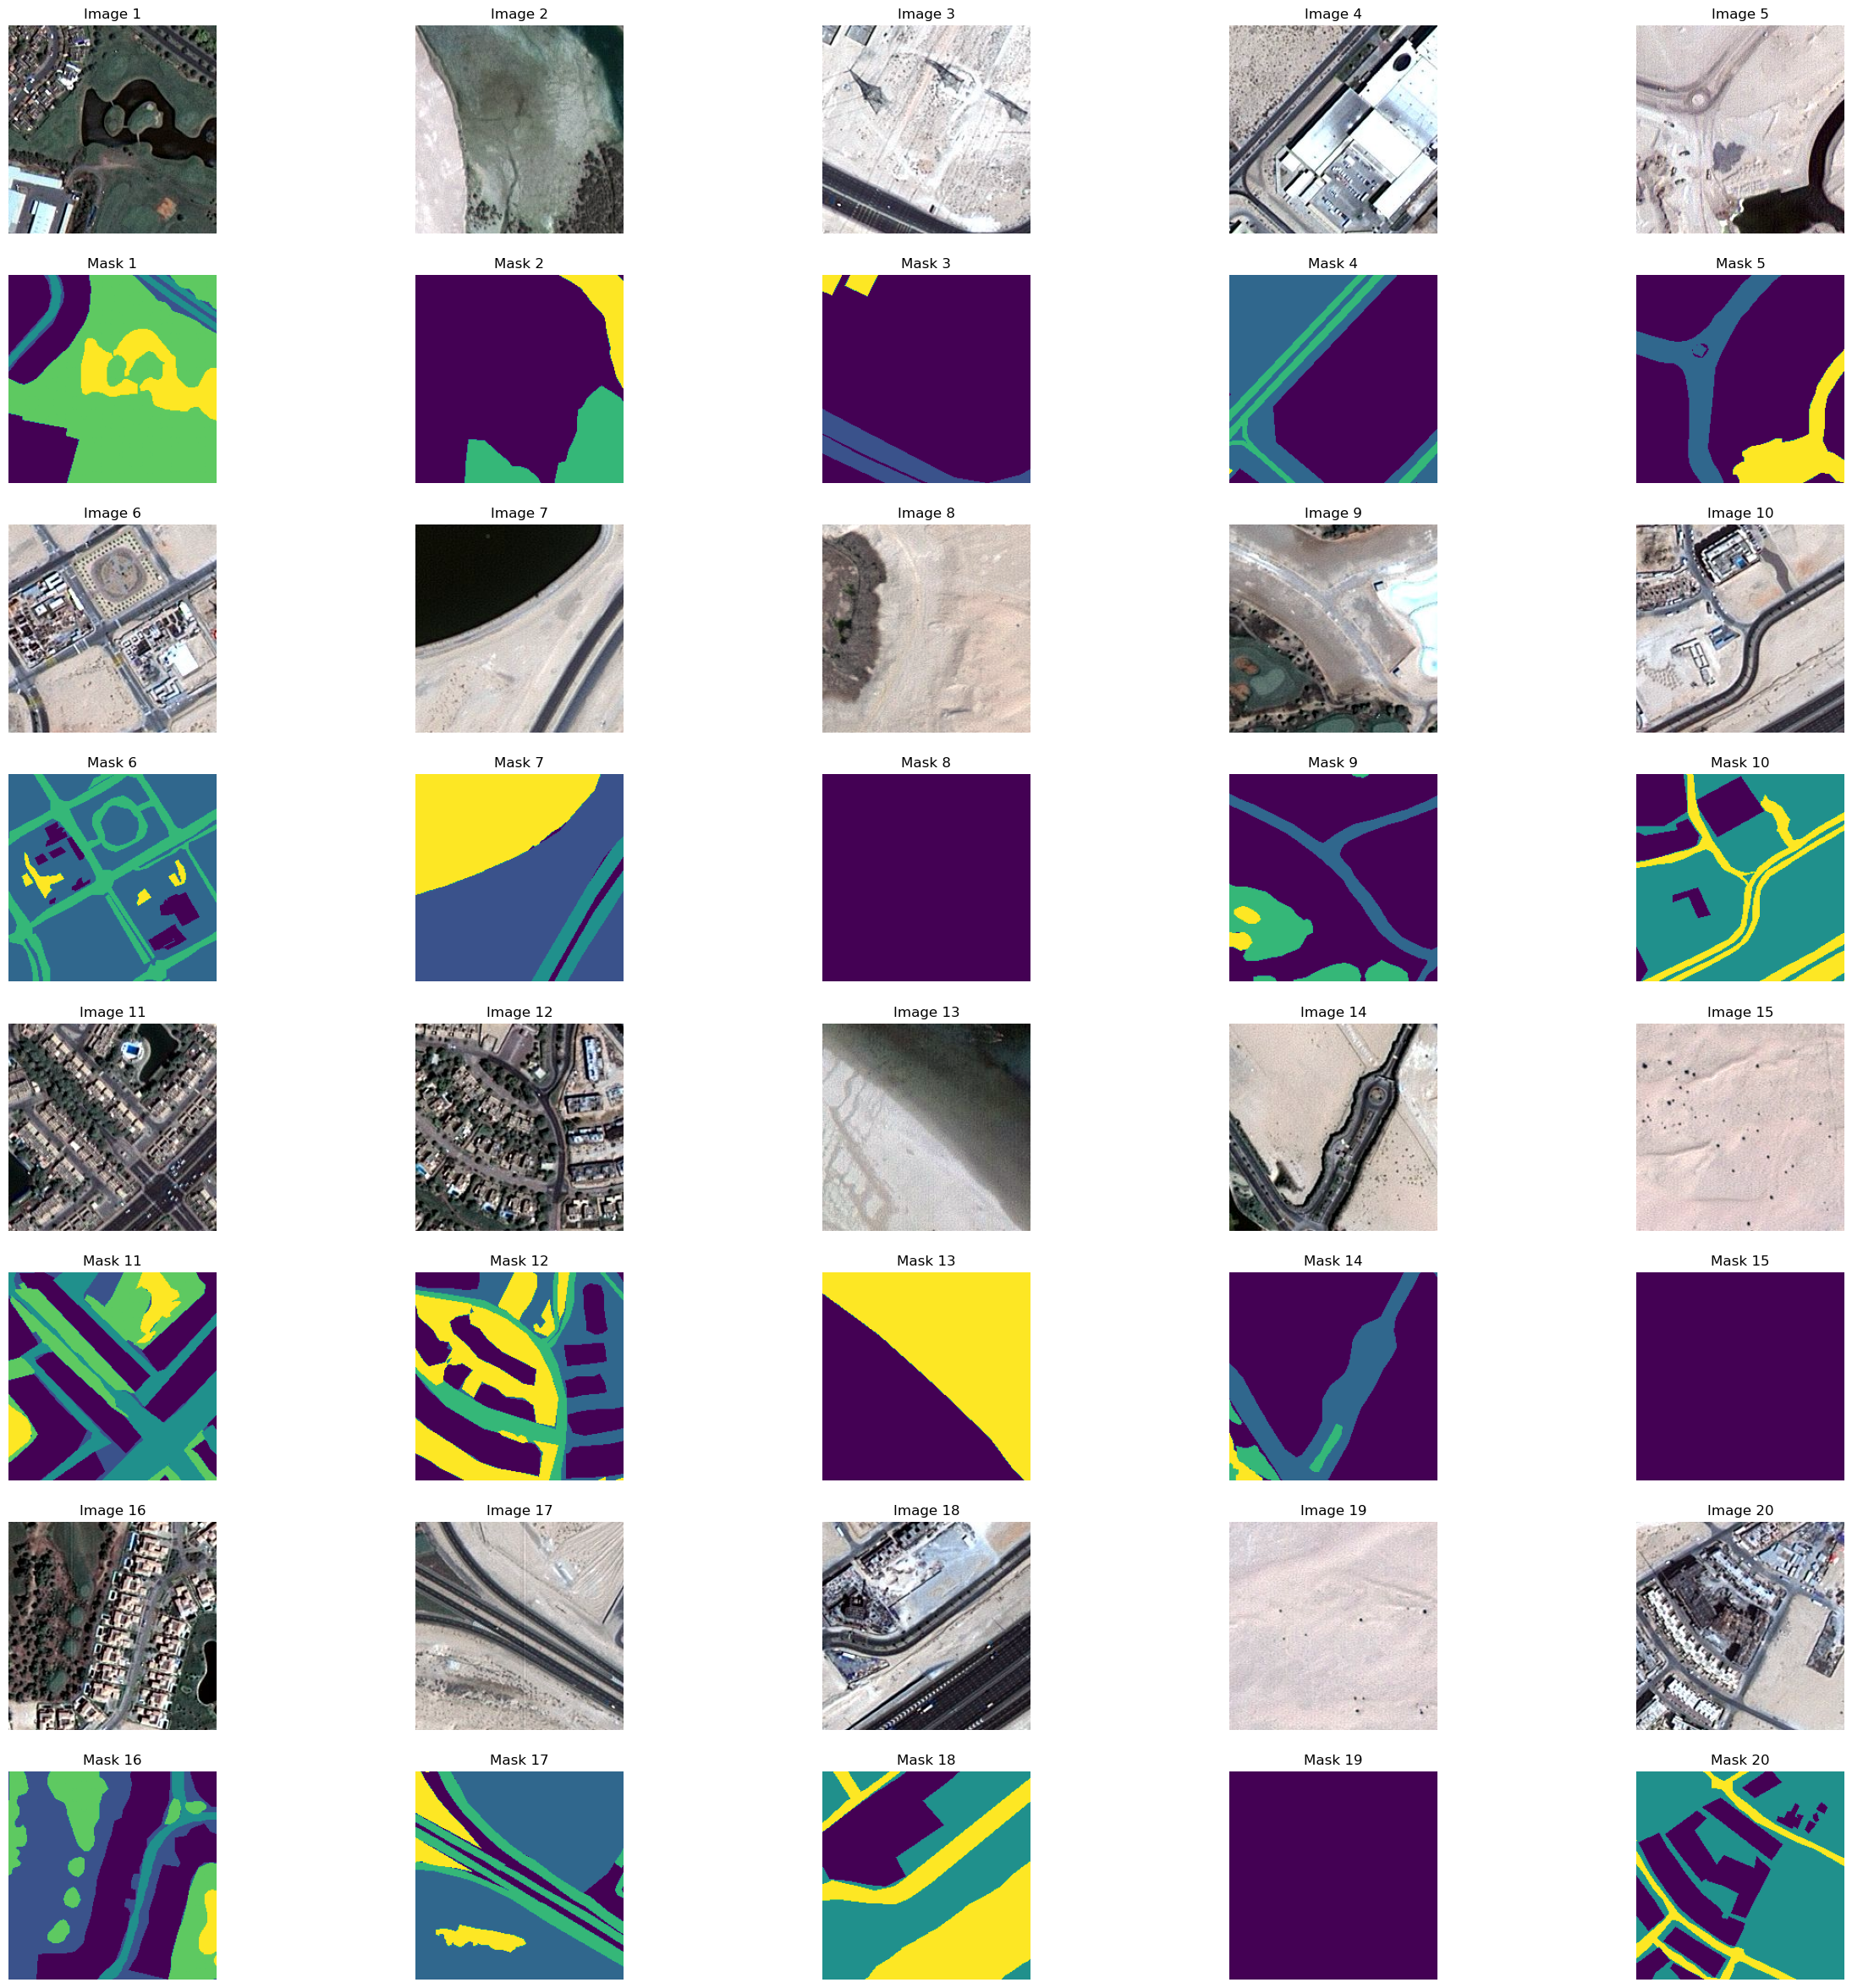

In [307]:
plt.figure(figsize=(30,30))
x, y = 5, 4
count=1
for i in range(y):
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = random.randint(0, len(image_dataset))
        plt.imshow(np.reshape(image_dataset[pos], (patch_size, patch_size, 3)))
        #plt.imshow(image_dataset[pos].astype('int'))
        plt.title('Image {}'.format(count))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        plt.imshow(np.squeeze(labels[pos].astype('int')))
        plt.title('Mask {}'.format(count))
        plt.axis('off')
        count = count + 1
plt.show()

In [308]:
n_classes = len(np.unique(labels))
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

In [309]:
labels_cat.shape

(1647, 224, 224, 6)

In [310]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [311]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #

In [312]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [313]:
IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS

(224, 224, 3)

In [314]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)



In [315]:


################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #model.summary()
    
    return model

In [316]:
metrics=['accuracy', jacard_coef]

In [317]:
model=multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS) #use when training model
#model=load_model('model.hdf5')

In [318]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 224, 224, 16  448         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_27 (Dropout)           (None, 224, 224, 16  0           ['conv2d_57[0][0]']              
                                )                                                           

In [319]:
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)

In [320]:
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

In [321]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    callbacks=callback,
                    validation_data=(X_test, y_test), 
                    shuffle=False)

#run time (local): about 1.5 minutes per epoch, for max 100 epochs, maximum 2.5 hours
#realistically - ran for 81 epochs, total ~120 minutes. Jac. Coeff: 0.7745

Epoch 1/100
83/83 [==============================] - ETA: 0s - loss: 0.9997 - accuracy: 0.5291 - jacard_coef: 0.2414
Epoch 1: val_loss improved from inf to 0.98368, saving model to model.hdf5
83/83 [==============================] - 93s 1s/step - loss: 0.9997 - accuracy: 0.5291 - jacard_coef: 0.2414 - val_loss: 0.9837 - val_accuracy: 0.6407 - val_jacard_coef: 0.3720 - lr: 0.0010
Epoch 2/100
83/83 [==============================] - ETA: 0s - loss: 0.9672 - accuracy: 0.6711 - jacard_coef: 0.3961
Epoch 2: val_loss improved from 0.98368 to 0.96449, saving model to model.hdf5
83/83 [==============================] - 88s 1s/step - loss: 0.9672 - accuracy: 0.6711 - jacard_coef: 0.3961 - val_loss: 0.9645 - val_accuracy: 0.7038 - val_jacard_coef: 0.4568 - lr: 0.0010
Epoch 3/100
83/83 [==============================] - ETA: 0s - loss: 0.9527 - accuracy: 0.7264 - jacard_coef: 0.4777
Epoch 3: val_loss improved from 0.96449 to 0.96248, saving model to model.hdf5
83/83 [=============================

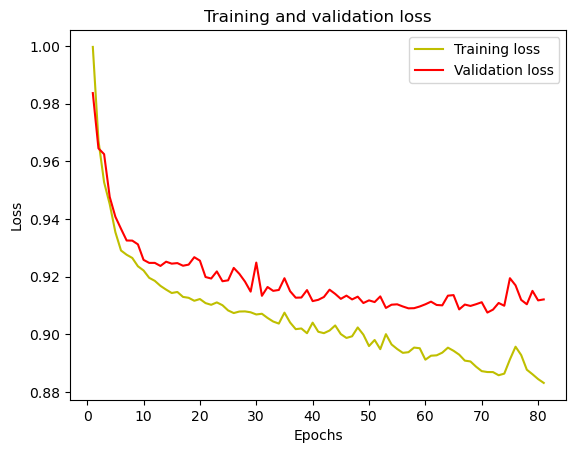

In [330]:
#plot the training and validation accuracy and loss at each epoch
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



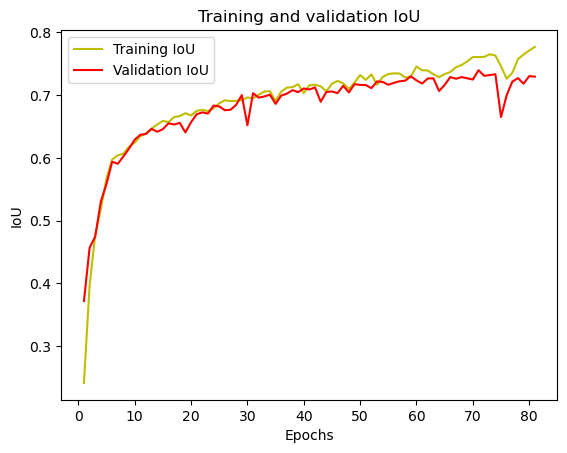

In [331]:
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [332]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

11/11 [==============================] - 5s 460ms/step


In [333]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.60200197


In [334]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 34ms/step


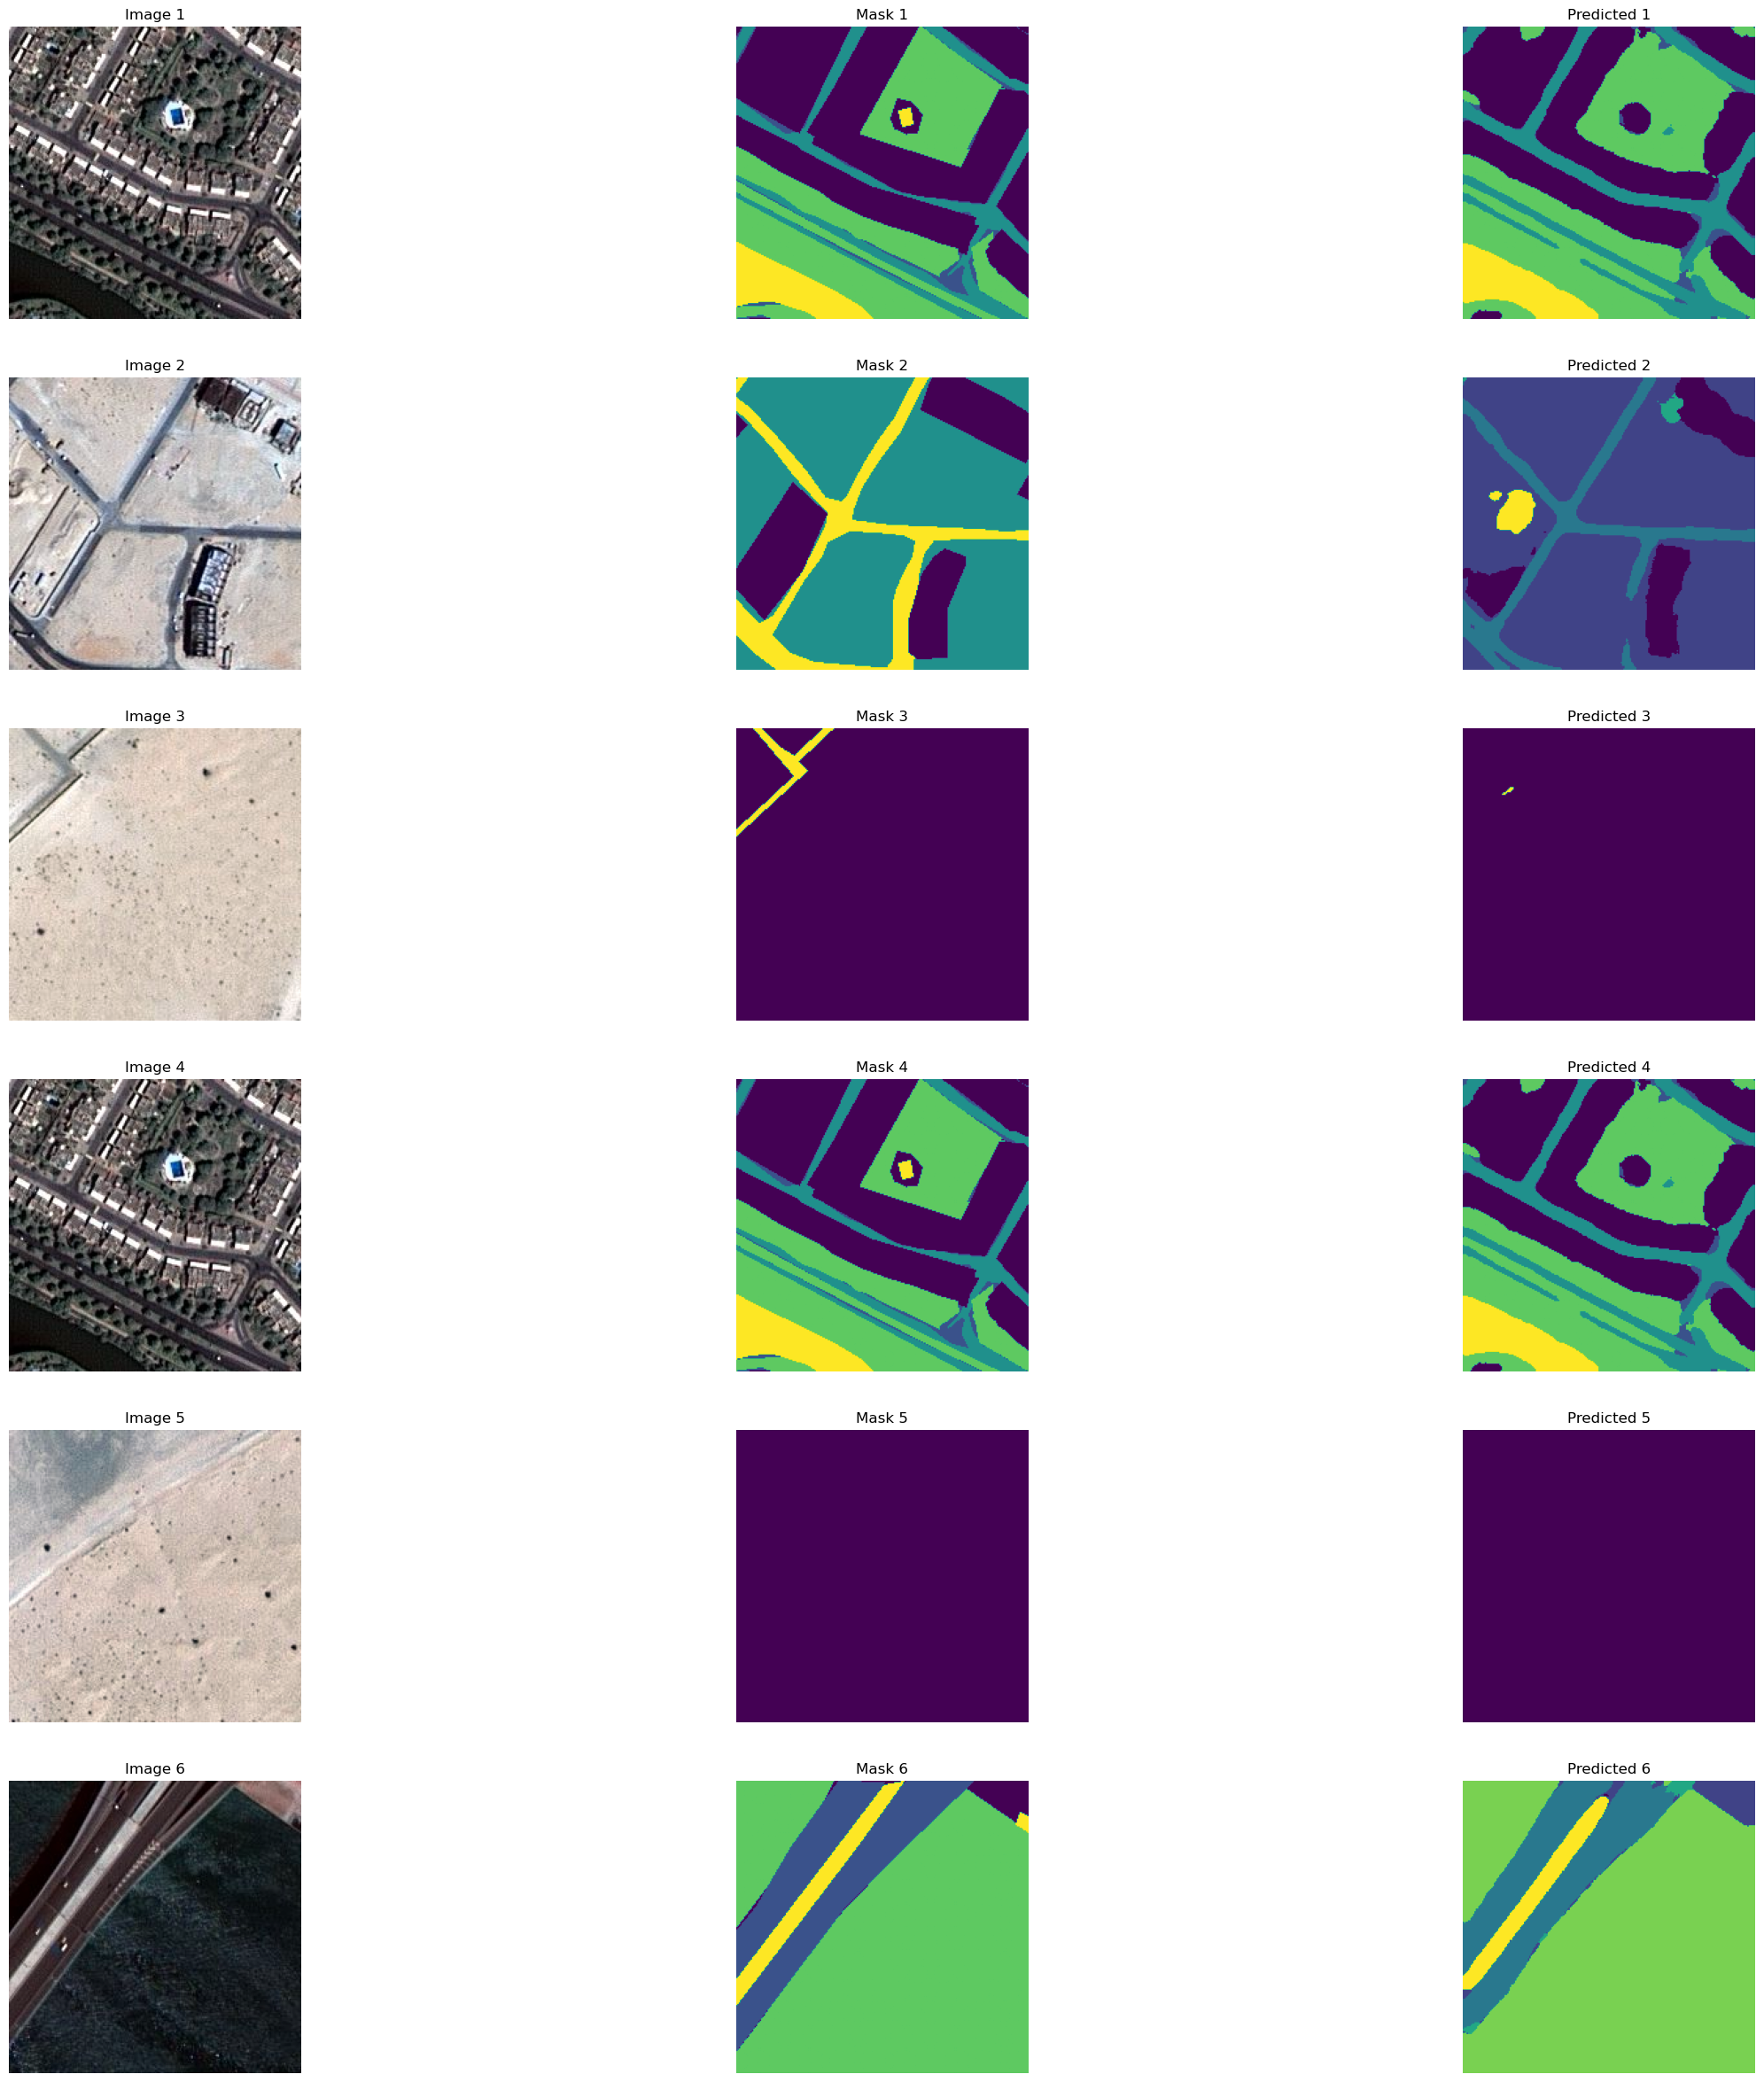

In [335]:
import random

plt.figure(figsize=(30,30))
x, y = 3, 2
count=1
for i in range(y):
    for j in range(x):
        
        test_img_number = random.randint(0, len(X_test))
        test_img = X_test[test_img_number]
        ground_truth=y_test_argmax[test_img_number]

        test_img_input=np.expand_dims(test_img, 0)
        prediction = (model.predict(test_img_input))
        predicted_img=np.argmax(prediction, axis=3)[0,:,:]
        
        plt.subplot(y*3, x, i*3*x+j*3+1)
        plt.imshow(test_img)
        plt.title('Image {}'.format(count))
        plt.axis('off')

        plt.subplot(y*3, x, (i*3)*x+j*3+2)
        plt.imshow(ground_truth)
        plt.title('Mask {}'.format(count))
        plt.axis('off')

        plt.subplot(y*3, x, (i*3)*x+j*3+3)
        plt.imshow(predicted_img)
        plt.title('Predicted {}'.format(count))
        plt.axis('off')
        count = count + 1
plt.show()

In [328]:
#img_test = cv2.imread("/Users/arnavvyas/Downloads/Purdue/satellite_test_img.jpeg", 1)

#img_test_input=np.expand_dims(test_img, 0)
#prediction_var = (model.predict(img_test_input))
#predicted_img=np.argmax(prediction_var, axis=3)[0,:,:]

In [329]:
#image = cv2.imread("/Users/arnavvyas/Downloads/Purdue/satellite_test_img.jpg", 1)
#SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
#SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
#image = Image.fromarray(image)
#image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
#image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
#image = np.array(image)

#img_test_input=np.expand_dims(image, 0)
#prediction_var = (model.predict(img_test_input))
#predicted_img=np.argmax(prediction_var, axis=3)[0,:,:]

#plt.figure(figsize=(30,30))
#plt.subplot(y*2, x, i*2*x+j*2+1)
#plt.imshow(image)
#plt.title('Image')
#plt.axis('off')


#plt.subplot(y*2, x, (i*2)*x+j*2+2)
#plt.imshow(predicted_img)
#plt.title('Predicted')
#plt.axis('off')